In [63]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Lambda, Concatenate, Conv2DTranspose
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K 
import numpy as np
import os
import pickle
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
img_width, img_height = 224, 224
train_data_dir = './dataset/images/'
validation_data_dir = './data_val/images/'
nb_train_samples = 127321
nb_validation_samples = 250
epochs = 50
batch_size = 16

In [5]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(20, activation='softmax')(x)

# this is the model we will train
VGG = Model(inputs=base_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

VGG.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
base_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
resnet = Model(inputs=base_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

#resnet.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 16682 images belonging to 20 classes.
Found 8351 images belonging to 20 classes.


In [24]:
# checkpoint
filepath="VGG16-finetuned_last3-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
VGG.fit_generator(train_generator, 16682 // batch_size, epochs=30,validation_data=validation_generator, validation_steps=8351//batch_size,
           callbacks=callbacks_list)

Epoch 1/30
1043/1042 [==============================] - 181s 174ms/step - loss: 0.7165 - acc: 0.6659 - val_loss: 0.5794 - val_acc: 0.6948
Epoch 2/30
1043/1042 [==============================] - 179s 171ms/step - loss: 0.7194 - acc: 0.6652 - val_loss: 0.5733 - val_acc: 0.6948
Epoch 3/30
1043/1042 [==============================] - 177s 170ms/step - loss: 0.7177 - acc: 0.6643 - val_loss: 0.5733 - val_acc: 0.6946
Epoch 4/30
1043/1042 [==============================] - 178s 171ms/step - loss: 0.7141 - acc: 0.6667 - val_loss: 0.5686 - val_acc: 0.6950
Epoch 5/30
1043/1042 [==============================] - 179s 172ms/step - loss: 0.7223 - acc: 0.6632 - val_loss: 0.5753 - val_acc: 0.6948
Epoch 6/30
1043/1042 [==============================] - 179s 172ms/step - loss: 0.7123 - acc: 0.6692 - val_loss: 0.5712 - val_acc: 0.6952
Epoch 7/30
1043/1042 [==============================] - 179s 172ms/step - loss: 0.7201 - acc: 0.6679 - val_loss: 0.5735 - val_acc: 0.6952
Epoch 8/30
1043/1042 [============

In [15]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [16]:
for layer in VGG.layers[0:15]:
    layer.trainable = False
for layer in VGG.layers[15: ]:
    layer.trainable = True

In [17]:
from keras.optimizers import SGD

In [18]:
VGG.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
filepath="resnet50-full_finetuned-{epoch:02d}-{val_acc:.2f}.hdf5"

In [14]:
VGG.fit_generator(train_generator, 22345 // batch_size, epochs=15,validation_data=validation_generator, validation_steps=3885//batch_size,
           callbacks=callbacks_list)

Epoch 1/15
1397/1396 [==============================] - 693s 496ms/step - loss: 1.0821 - acc: 0.6205 - val_loss: 1.1861 - val_acc: 0.6654
Epoch 2/15
1397/1396 [==============================] - 692s 495ms/step - loss: 0.8436 - acc: 0.6886 - val_loss: 1.1643 - val_acc: 0.6638
Epoch 3/15
1397/1396 [==============================] - 706s 506ms/step - loss: 0.7354 - acc: 0.7231 - val_loss: 1.1662 - val_acc: 0.6824
Epoch 4/15
1397/1396 [==============================] - 696s 498ms/step - loss: 0.6551 - acc: 0.7478 - val_loss: 1.1829 - val_acc: 0.6824
Epoch 5/15
1397/1396 [==============================] - 698s 500ms/step - loss: 0.5886 - acc: 0.7734 - val_loss: 1.2579 - val_acc: 0.6824
Epoch 6/15
1397/1396 [==============================] - 697s 499ms/step - loss: 0.5243 - acc: 0.7938 - val_loss: 1.2500 - val_acc: 0.6811
Epoch 7/15
1397/1396 [==============================] - 700s 501ms/step - loss: 0.4902 - acc: 0.8093 - val_loss: 1.3270 - val_acc: 0.6903
Epoch 8/15
1397/1396 [============

In [2]:
resnet = load_model('resnet50-fulltrain-improvement-11-0.70.hdf5')

In [3]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [4]:
for num, layer in enumerate(resnet.layers):
    print(num, layer.name, layer.input_shape)

0 input_1 (None, None, None, 3)
1 conv1 (None, None, None, 3)
2 bn_conv1 (None, None, None, 64)
3 activation_1 (None, None, None, 64)
4 max_pooling2d_1 (None, None, None, 64)
5 res2a_branch2a (None, None, None, 64)
6 bn2a_branch2a (None, None, None, 64)
7 activation_2 (None, None, None, 64)
8 res2a_branch2b (None, None, None, 64)
9 bn2a_branch2b (None, None, None, 64)
10 activation_3 (None, None, None, 64)
11 res2a_branch2c (None, None, None, 64)
12 res2a_branch1 (None, None, None, 64)
13 bn2a_branch2c (None, None, None, 256)
14 bn2a_branch1 (None, None, None, 256)
15 add_1 [(None, None, None, 256), (None, None, None, 256)]
16 activation_4 (None, None, None, 256)
17 res2b_branch2a (None, None, None, 256)
18 bn2b_branch2a (None, None, None, 64)
19 activation_5 (None, None, None, 64)
20 res2b_branch2b (None, None, None, 64)
21 bn2b_branch2b (None, None, None, 64)
22 activation_6 (None, None, None, 64)
23 res2b_branch2c (None, None, None, 64)
24 bn2b_branch2c (None, None, None, 256)
25 ad

In [ ]:
from keras import backend as K

# with a Sequential model
last_conv1 = K.function([resnet.layers[0].input],
                                  [resnet.layers[169].output])
layer_output = get_3rd_layer_output([x])[0]

In [57]:
resnet.layers[166].output.get_shape(), resnet.layers[166].name

(TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(512)]),
 'res5c_branch2b')

In [40]:
from skimage.io import imread
from skimage.transform import resize

In [53]:
list_val = os.listdir('./data_val/images/aeroplane/')[:5]
imgs = []
for each_img in list_val:
    imgs.append(resize(imread(os.path.join('./data_val/images/aeroplane/', each_img)), (224, 224)))

/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
os.listdir('./data_val/images/aeroplane/')[5]

'2008_001227.jpg'

In [54]:
import numpy as np
new_test = np.asarray(imgs)
new_test.shape

(5, 224, 224, 3)

In [13]:
train_generator.class_indices

{'aeroplane': 0,
 'bird': 1,
 'bottle': 2,
 'car': 3,
 'cat': 4,
 'chair': 5,
 'dog': 6,
 'person': 7,
 'sofa': 8,
 'tvmonitor': 9}

In [55]:
preds = resnet.predict(new_test)
labels = np.zeros(preds.shape)
labels[preds>0.5] = 1
np.argmax(labels, axis=-1)

array([0, 0, 7, 0, 0])

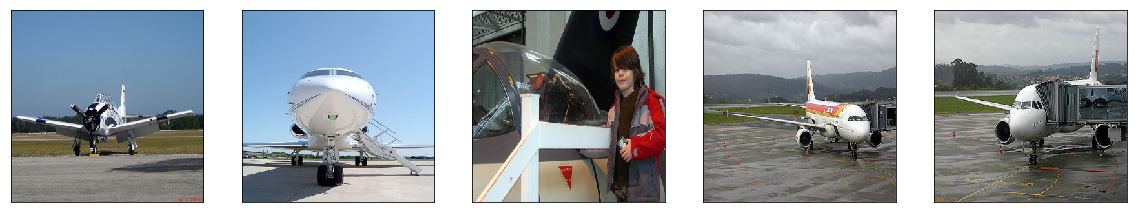

In [43]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
resnet.layers[5].output

<tf.Tensor 'res2a_branch2a/BiasAdd:0' shape=(?, ?, ?, 64) dtype=float32>

### Visualization

In [2]:
VGG = load_model('./VGG16-finetuned_last3-27-0.70.hdf5')

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [46]:
list_val = os.listdir('./data_val/images/person/')[45:50]
imgs = []
for each_img in list_val:
    imgs.append(resize(imread(os.path.join('./data_val/images/person/', each_img)), (224, 224)))

/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


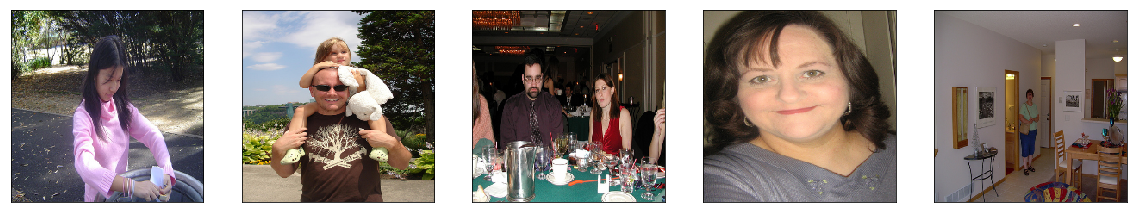

In [47]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [48]:
expanded = np.expand_dims(imgs[0], axis=0)
expanded.shape

(1, 224, 224, 3)

(1, 224, 224, 3)

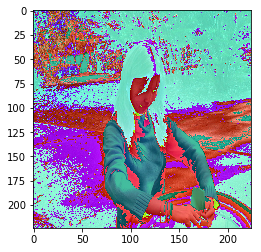

In [57]:
processed = preprocess_input(expanded)
plt.imshow(processed[0])
processed.shape

In [60]:
preds = VGG.predict(processed)
np.argmax(preds)

14

In [59]:
train_generator.class_indices

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [62]:
person_output = VGG.output[:, 14]

In [63]:
person_output

<tf.Tensor 'strided_slice_1:0' shape=(?,) dtype=float32>

In [64]:
last_conv_layer = VGG.get_layer('block5_conv3')

In [65]:
grads = K.gradients(person_output, last_conv_layer.output)[0]

In [66]:
grads.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

In [67]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
pooled_grads.shape

TensorShape([Dimension(512)])

In [71]:
iterate = K.function([VGG.input, K.learning_phase()], [pooled_grads, last_conv_layer.output[0]])

In [72]:
pooled_grads_value, conv_layer_output_value = iterate([processed, 0])

In [73]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [74]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(14, 14)

In [79]:
heatmap

array([[[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       ..., 
       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ..., 
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,

/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


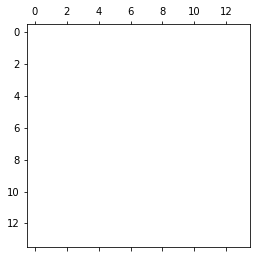

In [75]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [3]:
import cv2

In [77]:
list_val

['2008_000406.jpg',
 '2008_000407.jpg',
 '2008_000408.jpg',
 '2008_000413.jpg',
 '2008_000418.jpg']

In [78]:
img = cv2.imread('./data_val/images/person/2008_000406.jpg')

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./person_heatmap.jpg', superimposed_img)

True

In [91]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
#K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
#model = VGG16(weights='imagenet')
model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 66s 1us/step


In [92]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [15]:
from PIL import Image

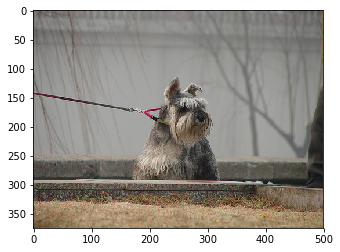

In [73]:
img = Image.open('./data_val/images/dog/2008_001070.jpg')
plt.imshow(img)

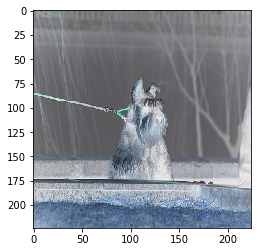

In [74]:
img_path = './data_val/images/dog/2008_001070.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)
plt.imshow(x)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)
#plt.imshow(x[0])

/home/sai/anaconda2/envs/DL/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


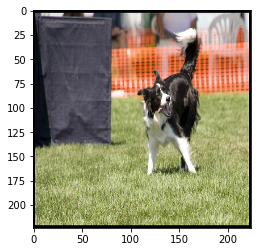

In [42]:
img =imread(img_path)
img = resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
plt.imshow(img[0])

In [95]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02097047', 'miniature_schnauzer', 0.55306584), ('n02097209', 'standard_schnauzer', 0.30575782), ('n02096177', 'cairn', 0.076469705)]


In [96]:
np.argmax(preds)

196

In [126]:
african_elephant_output = model.output[:, 196]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
#last_conv_layer = model.get_layer('block5_conv3')
#last_conv_layer = model.get_layer('block5_conv1')
#last_conv_layer = model.get_layer('add_7')
#last_conv_layer = model.get_layer('add_13')
#last_conv_layer = model.get_layer('add_16')

last_conv_layer = model.get_layer('res5b_branch2b')
# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input, K.learning_phase()], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x, 0])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [127]:
np.maximum(np.mean(conv_layer_output_value, axis=-1), 0)

array([[  3.60392119e-06,   7.35538788e-06,   7.23081303e-06,
          9.57015982e-06,   7.11331177e-06,   9.78639764e-06,
          8.30667523e-06],
       [  5.77287801e-06,   8.66437858e-06,   1.10119599e-05,
          8.23029404e-06,   8.85824193e-06,   1.31121615e-05,
          1.43468969e-05],
       [  8.02222985e-06,   7.18363526e-06,   5.90368381e-06,
          0.00000000e+00,   3.85100520e-07,   7.44120371e-06,
          1.20050809e-05],
       [  8.81390406e-06,   1.05282325e-05,   7.66303128e-06,
          1.44399464e-05,   1.48266263e-05,   1.57557879e-05,
          1.24475482e-05],
       [  1.03119028e-05,   1.18821827e-05,   1.09344874e-05,
          3.05814683e-05,   2.56831008e-05,   1.88131380e-05,
          9.37091409e-06],
       [  1.03420825e-05,   1.05517120e-05,   4.61306399e-06,
          1.19000015e-05,   5.24715779e-06,   5.30328271e-06,
          4.33527930e-06],
       [  6.99098246e-06,   6.53272900e-06,   2.76373248e-06,
          2.95884001e-06,   2.72

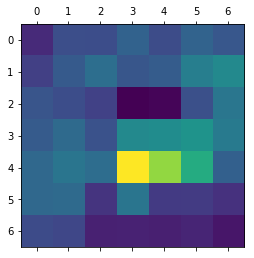

In [128]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [109]:
heatmap

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan]], dtype=float32)

In [129]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./dog_heatmap.jpg', superimposed_img)

True

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________